In [68]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
from pathlib import Path
from tqdm import tqdm

import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# import custom functions from src folder
module_path = str(Path.cwd() / "../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from NeuralNetwork import NeuralNetwork
from machine_learning import *

In [69]:
def plot_conf_matrix(confusion, accuracy, labels, ax):
    """
    plot confusion matrix
    """
    
    #Generate the confusion matrix
    cf_matrix = confusion_matrix(confusion["Truth"], confusion["Prediction"], normalize="true")
    cf_matrix = 100*np.round(cf_matrix, 4)
    group_percentages = ["{0:0.2%}".format(value/100) for value in cf_matrix.flatten()]
    annot = [f"{item}" for item in group_percentages]
    annot = np.asarray(annot).reshape(len(labels),len(labels))
    sn.heatmap(
            cf_matrix, 
            ax=ax, 
            annot=annot, 
            cmap='rocket', 
            linewidths=1.0, 
            linecolor='black',
            cbar = True, 
            square=True, 
            fmt='', 
            cbar_kws={"format": "%.0f%%", "shrink": 0.8},
            vmin=0,
            vmax=100,
            #annot_kws={"size": 24}
        )

    #ax.set_title('Confusion matrix\n\n', size=24)
    ax.set_xlabel('Predicted labels', size=14)
    ax.set_ylabel('True labels', size=14)

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(labels, size=12, rotation=20)
    ax.yaxis.set_ticklabels(labels, size=12, rotation=70)
    ax.tick_params(which="both", left=False, bottom=False, top=False, right=False)
    ax.set_title(f"Validation accuracy: {round(accuracy, 2)*100} %")
    #print(f"Accuracy: {accuracy}")

    ## Display the visualization of the Confusion Matrix.
    #fig.savefig(f"../results/figures/ResNet18_{N_TEST}_events_CUT_conf_matrix.pdf", format="pdf", bbox_inches='tight')
    return ax

In [70]:
def plot_data(df, ax):
    ax.set_title("Training data")
    df_red = df[df["color"] == "red"]
    sn.scatterplot(df_red, x="x1", y = "x2", c="red", alpha=0.5, ax=ax)
    
    df_green = df[df["color"] == "green"]
    sn.scatterplot(df_green, x="x1", y = "x2", c="green", alpha=0.5, ax=ax)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    ax.set_xlim(-25, 25)
    ax.set_xlim(-25, 25)

    return ax

In [71]:
def plot_results(df, ax, suptitle):
    ax.set_title(suptitle)
    sn.set_theme(style="whitegrid")
    #cmap = sn.cubehelix_palette(rot=-.2, as_cmap=True)

    c = ["darkred","red","lightcoral","grey", "palegreen","green","darkgreen"]
    v = [0,.15,.4,.5,0.6,.9,1.]
    l = list(zip(v,c))
    cmap = LinearSegmentedColormap.from_list('rg',l, N=256)

    sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue="Confidence", 
                   hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                    palette=cmap, legend=False)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    ax.set_xlim(-25, 25)
    ax.set_xlim(-25, 25)

    return ax


In [72]:
def plot_grid(model, device, fig, ax, nx:int = 100):
    x1_lim = 25
    x2_lim = 25
    x1 = np.linspace(-x1_lim, x1_lim, nx)
    x2 = np.linspace(-x2_lim, x2_lim, nx)
    xx1, xx2 = np.meshgrid(x1, x2)
    grid_df = pd.DataFrame(columns = ["x1", "x2"], index = range(len(xx1.flatten())))
    grid_df["x1"] = xx1.flatten()
    grid_df["x2"] = xx2.flatten()

    X_gridtest = torch.Tensor(np.dstack((grid_df["x1"], grid_df["x2"]))).to(torch.float32)[0]
    Y_gridtest = torch.zeros(X_gridtest.shape)
    gridtest_dataset = torch.utils.data.TensorDataset(X_gridtest, Y_gridtest)

    truth, logits = predict_classifier(model, gridtest_dataset, 2, 1, device)
    preds = torch.argmax(logits, dim=-1).flatten()
    grid_df["Prediction"] = preds
    grid_df["Truth"] = truth
    #Get softmax score for red
    grid_df["Confidence"] = torch.softmax(logits, dim=-1)[:,0,0]

    #plot_results(grid_df, ax, "Test data")
    
    c = ["darkred","red","lightcoral","grey", "palegreen","green","darkgreen"]
    v = [0,.15,.4,.5,0.6,.9,1.]
    l = list(zip(v,c))
    cmap = LinearSegmentedColormap.from_list('rg',l, N=256)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)

    ax.hist2d(x= grid_df["x1"], y= grid_df["x2"], weights=grid_df["Confidence"], 
                bins = nx,
                norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                cmap=cmap)
    
    ax.set_xlim(-x1_lim, x1_lim)
    ax.set_ylim(-x2_lim, x2_lim)

    #fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'Softmax( M($\vec{x}$) )', ax=ax)

    return fig, ax

In [73]:
def word_to_int(df):
    # Red = 1, Green = 0
    df["class"] = 1
    df_copy = df.copy()
    mask = df_copy["color"] == "green"
    df.loc[mask, "class"] = 0
    return df

def label_maker(values, num_classes):
    labels = np.zeros((len(values), num_classes))
    for i, value in enumerate(values):
        labels[i][value] = 1
    return torch.Tensor(labels).to(torch.int)


In [74]:
# Set up device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [75]:
# Read data
trainfile = "train_n_5000_kr7_kg3_s1_vary_a1_False"
valfile = "val_n_5000_kr7_kg3_s1_vary_a1_False"
testfile = "x1_x2_circles"
ntrain = 250

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")

train_data = word_to_int(train_data)
val_data = word_to_int(val_data)

X_train = torch.Tensor(np.dstack((train_data["x1"][0:ntrain], train_data["x2"][0:ntrain]))).to(torch.float32)[0]
Y_train = label_maker(train_data["class"][0:ntrain], 2)

X_val = torch.Tensor(np.dstack((val_data["x1"], val_data["x2"]))).to(torch.float32)[0]
Y_val = label_maker(val_data["class"], 2)

X_test = torch.Tensor(np.dstack((test_data["x1"], test_data["x2"]))).to(torch.float32)[0]
Y_test = torch.zeros(X_test.shape)

In [76]:
train_data

,color,x1,x2,a1,a2,r1,r2,class
0,red,10.165875,-5.737768,5.523416,1.244737,10.361182,3,1
1,red,-8.313172,-10.893792,3.850098,1.267038,12.503745,3,1
2,green,-0.736831,-7.679405,4.609960,3.124176,10.714041,3,0
3,red,14.840760,-2.497519,6.079409,0.186908,12.091364,3,1
4,green,5.459488,10.155468,0.898411,0.754240,9.159098,3,0
...,...,...,...,...,...,...,...,...
4995,red,7.269948,6.533450,0.452712,2.025342,10.712534,3,1
4996,green,-5.422939,6.463178,1.929177,1.927284,9.001641,3,0
4997,green,-9.489099,-0.951813,2.925565,1.726531,9.529833,3,0
4998,red,0.280289,8.096733,1.402873,2.774431,10.829741,3,1


In [77]:
# Create datasets for pytorch
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

 13%|█▎        | 9/70 [00:00<00:02, 28.44it/s]

100%|██████████| 5000/5000 [00:04<00:00, 1137.68it/s]


<Axes: xlabel='Iteration'>

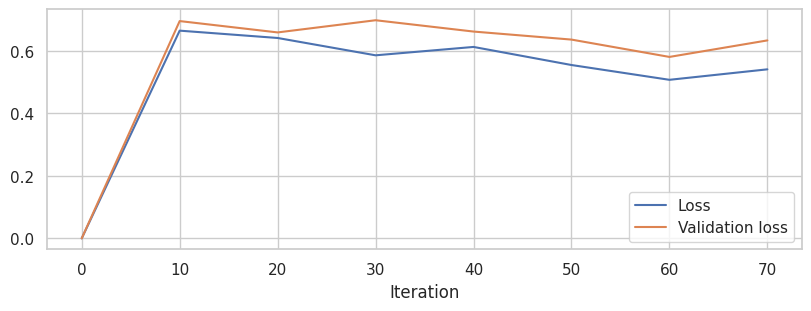

In [78]:
model = NeuralNetwork(L=1024, n_hidden=5, activation="relu", in_channels=2, out_channels=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
training_results = train_classifier(model, train_dataset, 
                         val_dataset, batchsize=2**8, epochs = 70, 
                         device = device, optimizer = optimizer)
truth, logits = predict_classifier(model, val_dataset, 2, 1, device)
preds = torch.argmax(logits, dim=-1).flatten()
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 3), layout="constrained")
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs)

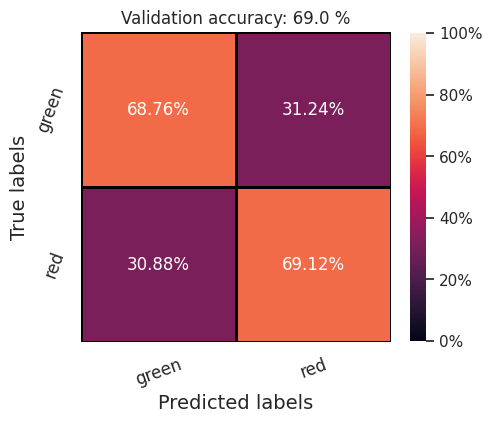

In [79]:
val_data["Prediction"] = preds
val_data["Truth"] = truth
accuracy = accuracy_score(truth, preds, normalize=True)
fig, ax = plt.subplots(1,1, figsize=(5, 5))
ax = plot_conf_matrix(val_data, accuracy, ["green", "red"], ax=ax)

In [80]:
truth, logits = predict_classifier(model, test_dataset, 2, 1, device)
preds = torch.argmax(logits, dim=-1).flatten()
test_data["Prediction"] = preds
test_data["Truth"] = truth
#Get softmax score for green
test_data["Confidence"] = torch.softmax(logits, dim=-1)[:,0,1]

100%|██████████| 376/376 [00:00<00:00, 1135.67it/s]


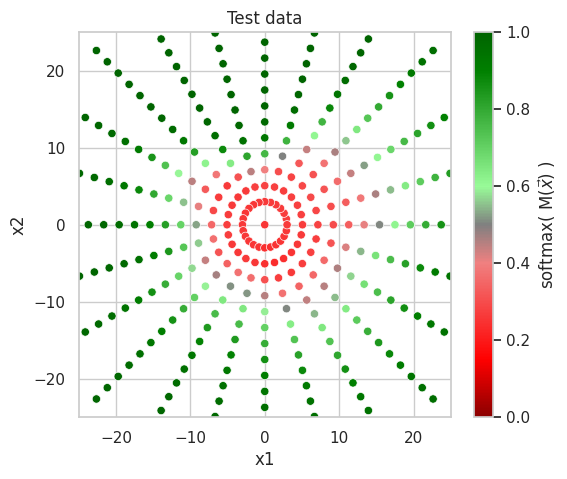

In [81]:
fig, ax = plt.subplots(1,1, figsize=(6, 5))
plot_results(test_data, ax, "Test data")
c = ["darkred","red","lightcoral","grey", "palegreen","green","darkgreen"]
v = [0,.15,.4,.5,0.6,.9,1.]
l = list(zip(v,c))
cmap = LinearSegmentedColormap.from_list('rg',l, N=256)
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'softmax( M($\vec{x}$) )', ax=ax)

  1%|          | 114/10000 [00:00<00:08, 1139.37it/s]

100%|██████████| 10000/10000 [00:08<00:00, 1141.43it/s]


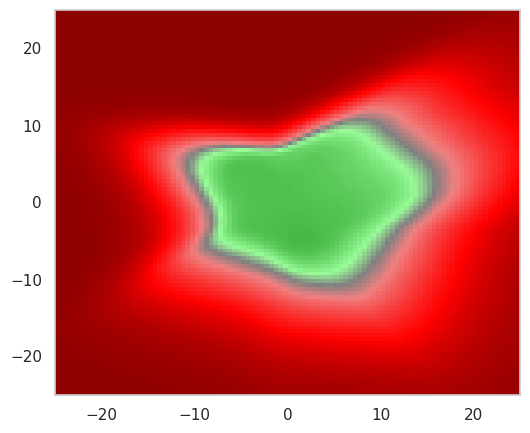

In [82]:
fig, ax = plt.subplots(1,1, figsize=(6, 5))
fig, ax = plot_grid(model, device, fig, ax)

In [84]:

# Plot animation
n_data = [10, 40, 80, 120, 150, 200, 250, 300, 500, 900, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3300, 3600]

for i in range(len(n_data)):

    # Fresh validation dataframe
    val_data = pd.read_csv(f"../data/{valfile}.csv")
    val_data = word_to_int(val_data)

    # Create datasets
    train_dataset = torch.utils.data.TensorDataset(X_train[0:n_data[i]], Y_train[0:n_data[i]])

    # Create new model
    model = NeuralNetwork(L=1024, n_hidden=5, activation="relu", in_channels=2, out_channels=2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train model
    training_results = train_classifier(model, train_dataset, 
                            val_dataset, batchsize=2**8, epochs = 70, 
                            device = device, optimizer = optimizer)
    
    # Predict on new model
    truth, logits = predict_classifier(model, val_dataset, 2, 1, device)
    preds = torch.argmax(logits, dim=-1).flatten()
    val_data["Prediction"] = preds
    val_data["Truth"] = truth
    #Get softmax score for green
    val_data["Confidence"] = torch.softmax(logits, dim=-1)[:,0,1]
    accuracy = accuracy_score(val_data["Truth"], val_data["Prediction"], normalize=True)

    # Save prediction
    #

    # Plot
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")
    
    axs[0][0] = plot_data(train_data[0:n_data[i]], axs[0][0])
    axs[0][1] = plot_conf_matrix(val_data, accuracy, ["green", "red"], axs[0][1])
    fig, axs[1][0] = plot_grid(model, device, fig, axs[1][0])
    axs[1][1] = plot_results(val_data, axs[1][1], "Val population")
    
    c = ["darkred","red","lightcoral","grey", "palegreen","green","darkgreen"]
    v = [0,.15,.4,.5,0.6,.9,1.]
    l = list(zip(v,c))
    cmap = LinearSegmentedColormap.from_list('rg',l, N=256)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'P(g|$x_1, x_2$)', ax=axs[1][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'P(g|$x_1, x_2$)', ax=axs[1][1])
    
    #fig.colorbar(axs[1][0], ax=axs[1][0])
    #axs[1][1] = plot_error(df[df["Truth"] == "red"], axs[1][1])
    #axs[1][2] = plot_error(df[df["Truth"] == "green"], axs[1][2])

    fig.suptitle(f"Number of datapoints: {n_data[i]}", size=16, fontweight="bold")

#plt.show()
    

  0%|          | 0/70 [00:00<?, ?it/s]

 39%|███▉      | 3905/10000 [00:03<00:05, 1141.45it/s]